In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from scipy import stats

from tqdm.auto import tqdm

plt.style.use('ggplot')

Задание №1
написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [2]:
#считываем данные
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-terehina-23/shared/problem1-reg_data.csv',sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-terehina-23/shared/problem1-auth_data.csv',sep=';')

посмотрим на данные: размер таблицы, типы переменных, наличие пропущенных значений,
наличие дубликатов, описательную статистику.

In [14]:
reg_data.shape

(1000000, 2)

In [15]:
auth_data.shape

(9601013, 2)

In [16]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [4]:
reg_data.dtypes

reg_ts               int64
uid                  int64
reg_date    datetime64[ns]
dtype: object

In [17]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [23]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [24]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [29]:
reg_data.describe()

,uid
count,1.000000e+06
mean,5.552354e+05
std,3.206011e+05
min,1.000000e+00
25%,2.776438e+05
50%,5.550455e+05
75%,8.329712e+05
max,1.110622e+06


In [27]:
auth_data.describe()

,uid
count,9.601013e+06
mean,3.347198e+05
std,2.832669e+05
min,1.000000e+00
25%,9.599700e+04
50%,2.579210e+05
75%,5.190250e+05
max,1.110622e+06


In [30]:
reg_data.loc[reg_data.duplicated()]

,reg_ts,uid


In [31]:
auth_data.loc[auth_data.duplicated()]

,auth_ts,uid


In [85]:
def retention(reg_data,auth_data,retention_days=[1,7,30],start_date=None):
    #reg_data - датафрейм с регистрациями в игре
    #auth_data - датафрейм с датами входа в игру
    #retention_days - дни за которые смотрим retention
    #start_date - дата регистрации от которой считаем retention
    
    #создадим колонку дата регистрации в формат datetime
    reg_data['reg_date'] = pd.to_datetime(reg_data.reg_ts, unit='s')
    #создадим колонку даты входов в игру в формате datetime
    auth_data['auth_date'] = pd.to_datetime(auth_data.auth_ts, unit='s')
    
    if start_date == None:
        start_date = reg_data.reg_date.min().date()
    reg_data = reg_data.query('reg_date >= @start_date')
    auth_data = auth_data.query('auth_date >= @start_date')
        
    full_data = reg_data.merge(auth_data, on='uid')
    #выделим когортный период
    full_data['retention_days'] = (full_data.auth_date - full_data.reg_date).dt.days
    #посчитаем retantion
    retention = full_data.groupby('retention_days')['uid'].nunique() / full_data['uid'].nunique()
    retention = retention.reset_index().rename(columns={'uid': 'retention'})
    
    if isinstance(retention_days, list):
        return retention[retention.retention_days.isin(retention_days)]
    else:
        return retention[retention.retention_days == retention_days]
    
   
    

In [89]:
retention(reg_data,auth_data,retention_days=10)

,retention_days,retention
10,10,0.05107


In [88]:
retention(reg_data,auth_data,start_date='2019-05-03')

,retention_days,retention
1,1,0.040299
7,7,0.043182
30,30,0.025025


Задание № 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
a_b_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-terehina-23/Проект_1_Задание_2.csv',sep=';')

In [93]:
a_b_test

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


посмотрим на данные: размер таблицы, типы переменных, наличие пропущенных значений,
наличие дубликатов, описательную статистику.

In [94]:
a_b_test.shape

(404770, 3)

In [95]:
a_b_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [96]:
a_b_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [97]:
a_b_test.loc[a_b_test.duplicated()]

,user_id,revenue,testgroup


In [6]:
a_b_test.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


Видим очень большие различия между минимальным и максимальным значением, а так же очень большое стандартное отклонение

In [20]:
#проверим нет ли в тестовых группах повторяющихся user_id
a_b_test.user_id.nunique()

404770

У нас в датафрейме 404770 строк и уникальных user_id  тоже 404770, соответственно повторяющихся нет

Сравним статаистику по ключевым метрикам для кажой отдельной группы

In [4]:
#выделим отдельно группу А и группу В из данных
a_group = a_b_test.query("testgroup == 'a'")
b_group = a_b_test.query("testgroup == 'b'")

In [11]:
a_group.head()

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a


In [12]:
b_group.head()

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b


Посчитаем ARPU для каждой из групп

In [37]:
arpu_a_group = a_group.revenue.sum()/a_group.user_id.nunique()

In [38]:
arpu_a_group

25.413719736965806

In [39]:
arpu_b_group = b_group.revenue.sum()/b_group.user_id.nunique()

In [40]:
arpu_b_group

26.75128659327863

In [41]:
#посчитаем разницу ARPU между группами
(arpu_b_group-arpu_a_group)/arpu_a_group*100

5.263168360069894

Вывод: ARPU тестовой группы(b) больше на 5%, чем ARPU контрольной группы(a).

Посмотрим на характер распределения в данной метрике. Для этого проведем тест Шапиро-Уилка для каждой группы

In [22]:
a = a_group['revenue'].sample(1000, random_state=17)

In [25]:
stats.shapiro(a)
#pvalue=0.0, отвергаем нулевую гипотезу-распределение не нормально

ShapiroResult(statistic=0.06614720821380615, pvalue=0.0)

In [26]:
b = b_group['revenue'].sample(1000,random_state=17)

In [27]:
stats.shapiro(b)
#pvalue=0.0, отвергаем нулевую гипотезу-распределение не нормально

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

Посомтрим на  распредление revenue в группах с помощью графиков boxplot

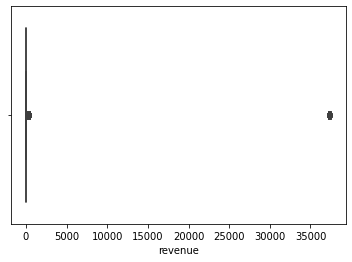

In [32]:
sns.boxplot(x=a_group["revenue"])

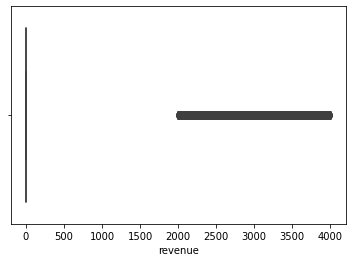

In [33]:
sns.boxplot(x=b_group["revenue"])

На графиках выше мы видим, что медиана значений у нас лежит около нулевой отметки. Это связано с тем, 
что в метрике мы считаем всех пользователей, (тех кто заплатил и тех кто нет) и соответственно неплатящих пользователй 
обычно больше.Далее видно, что в тестовой группе(b)значения распределны ~до 4000, а в контрольной(а) выше 35000

Посмотрим на значения, которые лежат выше медианы

In [35]:
a_group.revenue.quantile([0.5,0.95,0.999])

0.500      0.0
0.950      0.0
0.999    393.0
Name: revenue, dtype: float64

In [36]:
b_group.revenue.quantile([0.5,0.95,0.999])

0.500       0.000
0.950       0.000
0.999    3772.002
Name: revenue, dtype: float64

Исходя из полученных результатов мы можем сделать вывод о том, что
большинство пользователей  в группах не конвертируются в покупку, платящие пользователи составляют ~1% от всего числа
при этом в тестовой группе выручка 99.9 процентиля составляет 3772, а в контрольной
не смотря на то, что были показатели с высокой выручкой(видно на боксплоте),99.9 процентиль равен 393

Вывод:смотря на графики боксплот и результаты теста Шапиро-Уилка мы говорим о том, что
распределение по метрике ARPU в группах не нормальное. Смотря на квартили распределения понимаем, что 
плятящих пользователей около 1%(как и сказано в условии задачи:в контрольной группе 1928 игроков из 202103 оказались 
платящими, а в тестовой – 1805 из 202667,что составляет 0.95% и 0.89% соответственнo).
Поэтому выделить действительные аномальные различия по этой метрике нельзя.
Соответсвенно для интерпретации результатов А/В теста будем использовать другую метрику,
а именно: ARPPU(средняя прибыль от одного платящего пользователя)

Посчитаем ARPPU для каждой из групп.
Для этого отберем пользователей, у которых revenue > 0

In [61]:
control = a_group.query("revenue != 0")

In [45]:
control.head()

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a


In [46]:
test = b_group.query("revenue != 0")

In [47]:
test.head()

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b


In [49]:
arppu_control = control.revenue.sum()/control.user_id.nunique()

In [50]:
arppu_control

2663.9984439834025

In [52]:
arppu_test = test.revenue.sum()/test.user_id.nunique()

In [53]:
arppu_test

3003.6581717451522

In [54]:
#сравним ARPPU групп между собой
(arppu_test-arppu_control)/arppu_control*100

12.749997227996351

ARPPU тестовой группы на 13% больше, чем конторольной. Прежде чем проверять стат. значимы ли различия, посмотрим на характер распределения данных в метрике

Проведем тест Шапиро-Уилка

In [55]:
a = control['revenue'].sample(1000, random_state=17)

In [56]:
stats.shapiro(a)
#pvalue=0.0 отвергаем нулевую гипотезу - распределение не нормально

ShapiroResult(statistic=0.26476240158081055, pvalue=0.0)

In [57]:
b = test['revenue'].sample(1000, random_state =17)

In [58]:
stats.shapiro(b)
#pvalue = 1.2885095898576755e-15 отвергаем нулевую гипотезу - распределение не нормально 

ShapiroResult(statistic=0.9613320827484131, pvalue=1.2885095898576755e-15)

Посмотрим на распределение revenue в группах. Для этого посторим графики boxplot

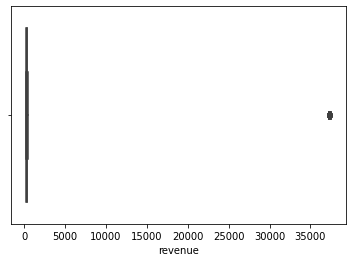

In [62]:
sns.boxplot(x=control["revenue"])

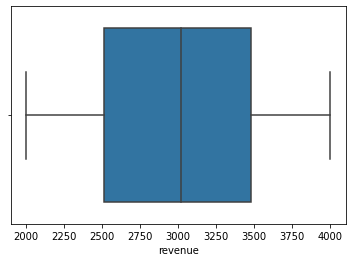

In [60]:
sns.boxplot(x=test["revenue"])

На графиках мы видим, что в контрольной группе большая часть значений лежит около 500, но есть и выбросы свыше 35000. Посомтрим на 95 и 99 процентили

In [64]:
control.revenue.quantile([0.5,0.90,0.95,0.999])

0.500      311.000
0.900      393.300
0.950    37299.650
0.999    37394.949
Name: revenue, dtype: float64

Мы видим, что 90% пользователей совершили покупки до 400 рублей, остальные 10% свыше 400 рублей, 6% из которых составили основную часть выручки(так называемые крупные клиенты)

Посмотри на боксплот тестовой группы. В ней медиана равна 3000 рублей и основная масса пользователей совершили покупки на сумму от 2500 до 3500 рублей. Посмотрим на процентили данной группы

In [65]:
test.revenue.quantile([0.25,0.5,0.75,0.90,0.95,0.999])

0.250    2513.000
0.500    3022.000
0.750    3478.000
0.900    3795.800
0.950    3891.800
0.999    3999.196
Name: revenue, dtype: float64

В тестовой группе мы видим, что основная масса это среднеплатежные пользователи. Здесь не наблюдается так называемых крупных клиентов, которые совершают покупки на большие суммы

Исходя из проведенного теста Шапиро-Уилка мы видим, что распределение в группах не нормальное, поэтому использовать для определения стат. значимости критерий t-test Стьюдента мы не можем. U-критерий Манна-Уитни, который является непараметрическим и используется в случае, если в данных есть выбросы, как у нас, мы использовать тоже не будем, так как очень сложно объяснить его результаты бизнесу. В данном случае нам подходит такой метод, как бутстрап.

Выдвинем гипотезы для проверки:

Н_0 - нулевая гипотеза - средняя выручка на платящего пользователя тестовой группы не отличается от средней выручки платящего пользователя контрольной группы


Н_1 - альтернативная гипотеза - средняя выручка на платящего пользователя тестовой группы отличается от средней выручки платящего пользователя контрольной группы

In [77]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    control_revenue, # числовые значения первой выборки
    test_revenue, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(control_revenue), len(test_revenue)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = control_revenue.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = test_revenue.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [78]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift


In [79]:
# будем пробовать бутстрап на эксп. распределении
x = control['revenue']
y = test['revenue']

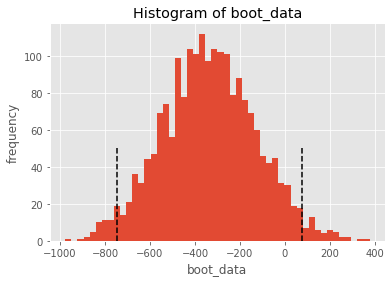

In [83]:
booted_data = get_bootstrap(x, y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [84]:
booted_data["p_value"]

0.10526938542841002

In [85]:
booted_data["ci"]

,0
0.025,-745.199741
0.975,73.961190


Согласно проведенному тесту мы видим, что 0 входит в доверительный интервал и значение pvalue > 0.05, что значит мы не можем отклонить нулевую гипотезу и статистически значимых различий в группах нет

Общий вывод: таким образом, проведя анализ результатов A/B теста мы поняли, что для оценки статистической значимости различий в группах нам лучше всего использовать метрику ARPPU, вместо ARPU. Мы не можем использовать метрику ARPU, так как в группах слишком много пользователей, которые не совершали покупки и на таких данных нам не увидеть аномальных различий. Поэтому мы отобрали только тех пользователей, которые совершили покупки, посчитали ARPPU и сравнили тестовую и контрольную группы с помощью метода бутстрап, который в свою очередь показал, что статистически значимых различий между группами не обнаружено и нулевая гипотеза не была отвергнута. Поэтому мы делаем вывод о том, что мы не можем распространять набор акционых предложений тестовой группы на всех пользователей и оставляем акции, которые были и ранее, то есть у контрольной группы.

Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики, на которые можно посмотреть для оценки результатов:

1 Метрики активных пользователей (DAU, WAU, MAU). Посмотреть сколько активных игроков было до тематического события и во время.

2 ARPPU - одной из цели тематического события является увеличение среднего дохода с платящего пользователя (то есть совершение большего количества покупок)

3 Average Number of Sessions  (среднее количество сессий при хороших резултатах должно увеличиться)

4 Конверсия в покупку - будет хорошим результатом, если помимо того, что пользователи получат за прохождение уровней они еще совершат другие покупки в игре

5 Lifetime таким образом можно посмотреть на то, как долго, в среднем, человек остаётся активен в проекте

6 Max Users Online - мы можем посмотреть сколько было пользоватлей онлайн во время проведения тематического события и вне его(чем больше пользователей онлайн, тем больше заинтересовнность данным событием)

7 New Users и Installs - количество новых пользователей, которые впервые открыли игру и количество установок(ведь целью является так же привлечение новых пользователей)

8 Retention - удержание пользователя, которые уже были в игре (процент пользователей, которые возвращались в игру во время тематического события)

9 Revenue - общий доход во время тематического события и вне его, увеличился ли или нет

10 Unit sales - посомотрим на то покупались ли еще какие-либо предметы в игре



Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

При данных изменениях можно помимо выше перечисленных метрик можно посмотреть еще на такие:

1 Churn by Level - отвал новых пользователей на уровне за период (покажет сколько пользователей ушли при непрохождении уровня и откате на предыдущий)

2 Users by Level - распределение игроков по уровню (покажет как игроки проходят уровни во ремя тематического события)

3 Average Session Length - средняя продолжительность сессий (при условии, что игроки будут окатываться на предыдущий уровень продолжительность сессии будет увеличиваться)